<H1>Import Libraries

In [1]:
# Utility libraries
import time
import os
import math
import random
from collections import Counter, defaultdict

# Data science libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# EDA library
from dataprep.eda import plot

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

# *** Remove comment to download stopwords for the first time ***
#nltk.download('stopwords') 
#nltk.download('punkt')
#nltk.download('wordnet')

import spacy

import re

from nltk.corpus import stopwords

from textwrap import wrap

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

NumExpr defaulting to 4 threads.


In [2]:
# import sys
# !{sys.executable} -m pip install spacy

# # Download spaCy's  'en' Model
# !{sys.executable} -m spacy download en

<H1> Read Datasets

In [3]:
narratives = pd.read_csv('Data/Narratives_All.csv')

nlpid = pd.read_csv('Data/NLPID.csv')
nlpid = nlpid.rename(columns={"rosc": "rosc_event", "endofevent": "death_event"})

In [ ]:
display(narratives.head())
display(nlpid.head())

<H1> Join Datasets on ID

In [5]:
df = pd.merge(narratives, nlpid, on=['pcrid'])

<H1> Preclean Data

In [6]:
# Drop duplicates and na
df_clean = df.drop_duplicates().copy()
df_clean = df_clean.dropna(axis=0)

# Remove numbers
def rem_nums(lis):
    result = ''.join([i for i in lis if not i.isdigit()])
    return result

df_clean['Chief Narrative'] = df_clean['Chief Narrative'].apply(rem_nums)

# Lowercase
df_clean['Chief Narrative'] = df_clean['Chief Narrative'].apply(lambda x: x.lower())

# Remove stopwords
def rem_stop(lis):
    
    stopWords = stopwords.words("english")
    
    words = str.split(lis);
    
    result = [word for word in words if not word in stopWords]
    result = ' '.join(result)
    
    return result 

df_clean['Chief Narrative'] = df_clean['Chief Narrative'].apply(rem_stop)

# Check for removed rows
diff = len(df)-len(df_clean)
print(f'Removed {diff} rows from the original dataset with {len(df)} records. {len(df_clean)} records remain.')

Removed 197 rows from the original dataset with 1825 records. 1628 records remain.


## point bi-serial correlation cont x bin

# Get Keywords

In [8]:
keywords = pd.read_csv('Data/keywords.csv', header = None).T
keywords.columns = keywords.iloc[0]
keywords=keywords.drop([0])
keys = list(keywords.columns)

<H1> Initial Exploration with Dataprep EDA

In [ ]:
plot(df_clean)

In [10]:
plot(df_clean,"rosc_event","death_event")

<H1> Exploratory Word Cloud

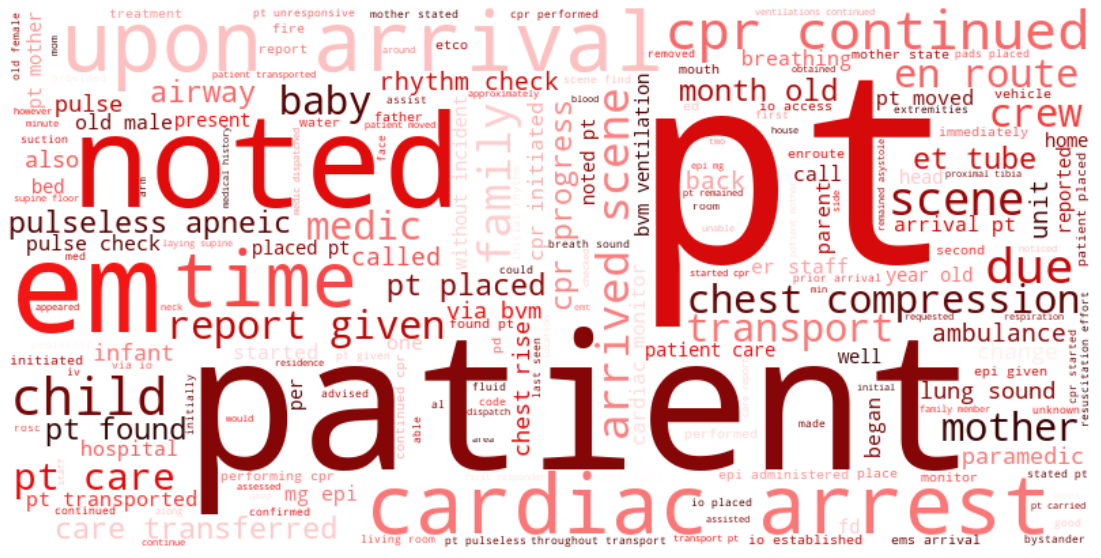

In [11]:
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 91%%, %d%%)" % random.randint(10, 100)

# Base stop words from NLTK
stop = stopwords.words("english")
text = " ".join(narr for narr in df_clean['Chief Narrative'])
wc = WordCloud(stopwords=stop, background_color="white",width=800, height=400).generate(text)

# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wc.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.show()

# <span style="color:red">Functions</span>

# Get ngrams

In [12]:
def bigrams(tokens):
    pairs = [ " ".join(pair) for pair in nltk.bigrams(tokens)]
    return pairs

def trigrams(tokens):
    pairs = [ " ".join(pair) for pair in nltk.trigrams(tokens)]
    return pairs

# Check if ngrams contain keywords

In [13]:
def checkword(keys, token):
    
    check = dict((k,0) for k in keys)
    
    for word in token:
        if word in check.keys():
            check[word] += 1
            
    return check

In [14]:
def checkword_binary(keys, token):
    
    check = dict((k,0) for k in keys)
    
    for word in token:
        if word in check.keys():
            check[word] = 1
            
    return check

# Tokenize

In [15]:
#WordNet
def lemmatize(tokenization):
    wnl = WordNetLemmatizer()
    lemmatized = []
    for word,tag in tokenization:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
        else:
            lemma = wnl.lemmatize(word, wntag)
        lemmatized.append(lemma)
                
    
    return lemmatized

def tokenize_ngram(df_clean):
    df_tokenized = df_clean.copy()

    # Tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    
    # Get unigrams
    df_tokenized['unigram'] = df_tokenized["Chief Narrative"].apply(lambda x: pos_tag(tokenizer.tokenize(x.lower())))
    
     # Lemmatize
    df_tokenized['unigram'] = df_tokenized["unigram"].apply(lemmatize)
    
    # Get bigrams and trigrams
    df_tokenized['bigrams'] = df_tokenized["unigram"].apply(lambda x: bigrams(x))
    df_tokenized['trigrams'] = df_tokenized["unigram"].apply(lambda x: trigrams(x))

    # Get ngrams
    df_tokenized['ngrams'] = df_tokenized["unigram"] + df_tokenized['bigrams'] + df_tokenized['trigrams']
    
    return df_tokenized

# Encode keywords and events

In [16]:
def encode_keys(df,column,keys):
    # Check for count of keywords in Chief Narrative
    df['keys'] = df[column].apply(lambda x: checkword(keys,x))

    # Turn keyword count into feature columns
    df2 = pd.concat([df.drop(['keys'], axis=1), df['keys'].apply(pd.Series)], axis=1)

    # Encode events
    labelencoder = LabelEncoder() 
    df2['rosc_event'] = labelencoder.fit_transform(df2['rosc_event']) 
    df2['death_event'] = labelencoder.fit_transform(df2['death_event'])
    return df2

In [17]:
def encode_keys_binary(df,column,keys):
    # Check for count of keywords in Chief Narrative
    df['keys'] = df[column].apply(lambda x: checkword_binary(keys,x))

    # Turn keyword count into feature columns
    df2 = pd.concat([df.drop(['keys'], axis=1), df['keys'].apply(pd.Series)], axis=1)

    # Encode events
    labelencoder = LabelEncoder() 
    df2['rosc_event'] = labelencoder.fit_transform(df2['rosc_event']) 
    df2['death_event'] = labelencoder.fit_transform(df2['death_event'])
    return df2

# Correlation heatmap

In [18]:
def correlation_heat_map(encoded_df,focus_col):
    # Get correlation matrix
    focus_cols = [focus_col]
    
    if focus_col == 'death_event':
        encoded_df = encoded_df.copy().drop(columns = ['rosc_event'])
    else:
        encoded_df = encoded_df.copy().drop(columns = ['death_event'])
        
    corrMatrix = encoded_df.corr()\
                        .filter(focus_cols)\
                        .drop(focus_cols)\
                        .dropna(axis=0)\

    # Take the n largest and n smallest correlations
    nlargest = corrMatrix.nlargest(10,focus_col)
    nsmallest = corrMatrix.nsmallest(10,focus_col)
    corrMatrix = nlargest.append(nsmallest).sort_values(by = focus_col, ascending = False)

    # Plot the correlation heatmap
    plt.rcParams["figure.figsize"]=10,10
    sns.heatmap(corrMatrix, xticklabels=True, yticklabels=True, center=0, annot=True)
    plt.show()

# <span style="color:red">Pipeline for Provided Keywords</span>

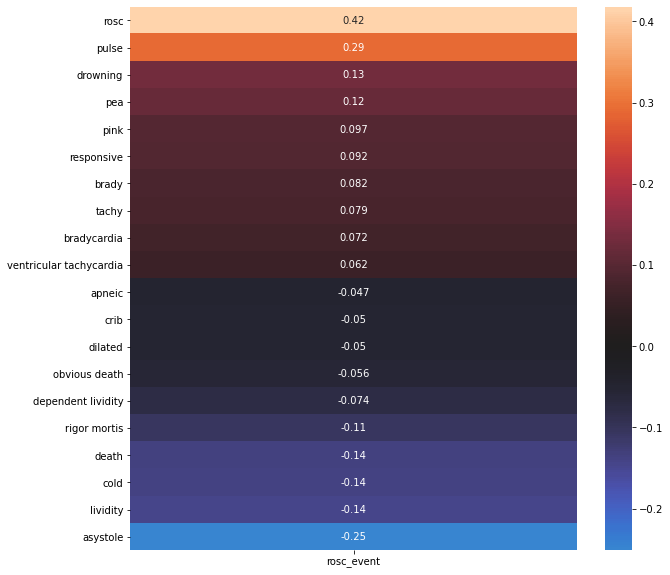

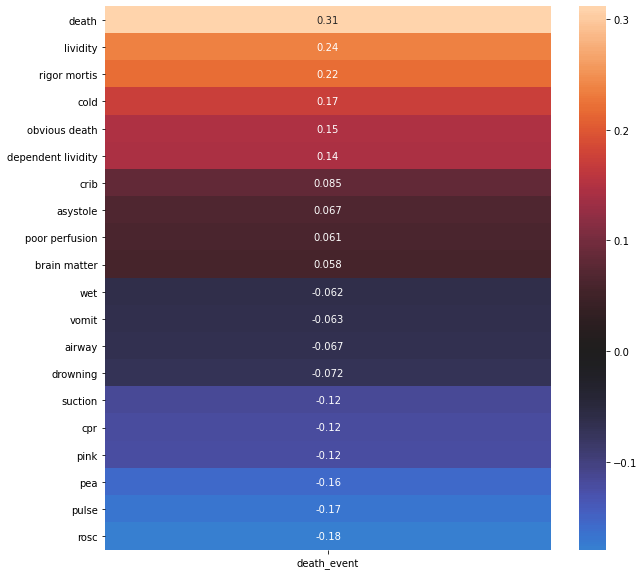

In [19]:
# Tokenize and get ngrams
df_tokenized = tokenize_ngram(df_clean)

# Encode token counts into feature columns
df_encoded = encode_keys(df_tokenized,'ngrams',keys)

# Get correlation heatmap for rosc
correlation_heat_map(df_encoded,'rosc_event')

# Get correlation heatmap for death
correlation_heat_map(df_encoded,'death_event')

37 out of 73 key phrases (50.68%) appear less than 25 times


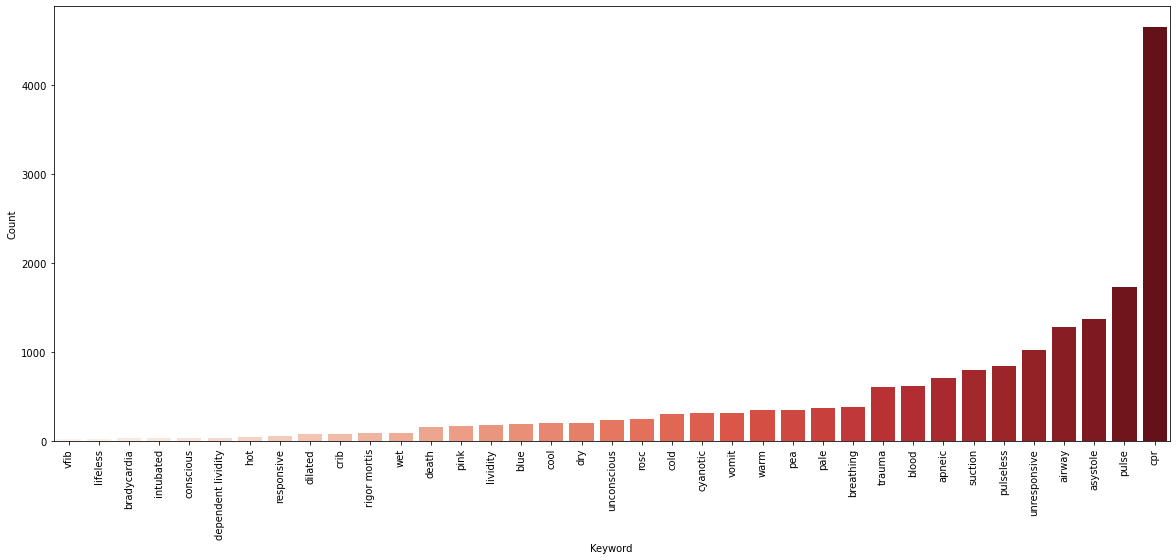

In [20]:
# Bar plot of provided keywords

keyword_df = df_encoded.loc[:,'airway':'wet']
keyword_df.loc['Total']= keyword_df.sum()
keyword_df = pd.DataFrame({'Keyword':list(keyword_df.columns),
                          'Count':list(keyword_df.loc['Total'])}).sort_values(by=['Count']).reset_index(drop=True)

len_total = len(keyword_df)
keyword_df = keyword_df.query('Count > 25')
len_cut = len(keyword_df)
percent = len_cut/len_total
print('{} out of {} key phrases ({:2.2%}) appear less than 25 times'.format(len_cut,len_total, percent))

plt.rcParams["figure.figsize"]=20,8
ax = sns.barplot(x=keyword_df["Keyword"], y=keyword_df["Count"], palette="Reds")
for item in ax.get_xticklabels():
    item.set_rotation(90)

# <span style="color:red">Pipeline for Blind Run Keywords</span>

# Explore token frequency

In [21]:
def explore_freq(grams):
    # Tokenize and get ngrams
    df_tokenized = tokenize_ngram(df_clean)

    # Get all tokens into one list
    all_tokens_list = df_tokenized[grams].tolist()

    # Flatten the list
    all_tokens_list = [item for sublist in all_tokens_list for item in sublist]

    # Get types and tokens
    print("Our dataset contains {} lexical types".format(len(set(all_tokens_list))))
    print("Our dataset contains {} lexical tokens".format(len(all_tokens_list)))

    # Count all the tokens
    counts = Counter(all_tokens_list)

    # Group the tokens by frequency
    frequencies = [0]*8
    for w in counts:
      if counts[w] >= 128:
        frequencies[0] += 1
      elif counts[w] >= 64:
        frequencies[1] += 1
      elif counts[w] >= 32:
        frequencies[2] += 1
      elif counts[w] >= 16:
        frequencies[3] += 1
      elif counts[w] >= 8:
        frequencies[4] += 1
      elif counts[w] >= 4:
        frequencies[5] += 1
      elif counts[w] >= 2:
        frequencies[6] += 1
      else:
        frequencies[7] += 1
    print(frequencies)
    # Barplot of token frequency
    f,a = plt.subplots(1,1,figsize=(10,5))
    a.set(xlabel='Lexical types occuring more then n times', 
          ylabel='Number of lexical types',
          title = grams)

    labels = [128, 64, 32, 16, 8, 4, 2, 1]
    ax = sns.barplot(labels, frequencies, ax=a, order=labels, palette="husl")
    return counts

Our dataset contains 10205 lexical types
Our dataset contains 287832 lexical tokens
[409, 264, 398, 592, 804, 1291, 2168, 4279]


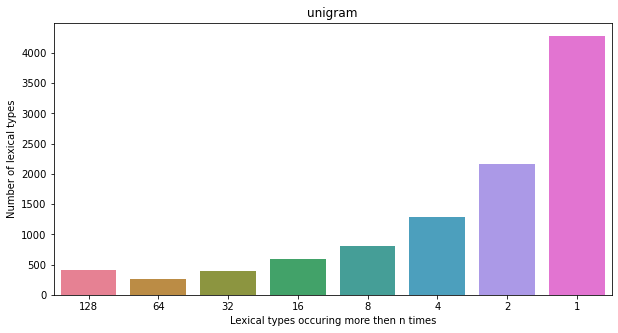

In [22]:
# Unigrams
counts_unigrams = explore_freq('unigram') #select 'unigram' 'bigrams' 'trigrams' 'ngrams'

Our dataset contains 118542 lexical types
Our dataset contains 286204 lexical tokens
[108, 204, 480, 1155, 2807, 6608, 19618, 87562]


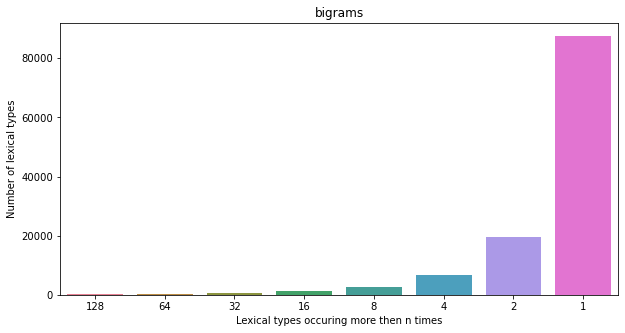

In [23]:
# Bigrams
counts_bigrams = explore_freq('bigrams') #select 'unigram' 'bigrams' 'trigrams' 'ngrams'

Our dataset contains 221979 lexical types
Our dataset contains 284576 lexical tokens
[4, 38, 111, 382, 1141, 3805, 17130, 199368]


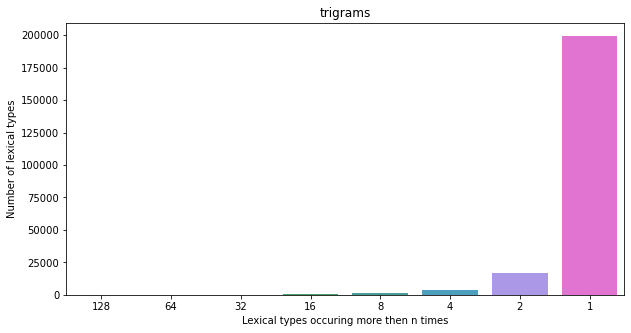

In [24]:
# Trigrams
counts_trigrams = explore_freq('trigrams') #select 'unigram' 'bigrams' 'trigrams' 'ngrams'

Our dataset contains 350726 lexical types
Our dataset contains 858612 lexical tokens
[521, 506, 989, 2129, 4752, 11704, 38916, 291209]


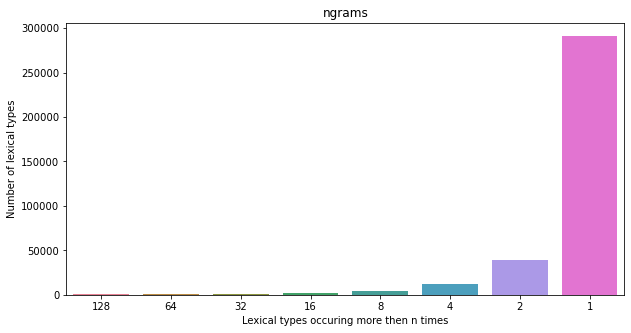

In [25]:
# N-grams
counts_ngrams = explore_freq('ngrams') #select 'unigram' 'bigrams' 'trigrams' 'ngrams'

In [26]:
def sample_words(counts, freq, disp = False):
    selected = [w for w in counts if counts[w] >= freq]
    if disp == True:
        print("\n",len(selected),"words appearing more than", freq ,"times\n")
        for line in wrap("   ".join(["{:50s}".format(w) for w in selected[:100]]), width=90):
          print(line)
    return selected

In [27]:
selected_keys = sample_words(counts_unigrams, 128, disp = True)


 409 words appearing more than 128 times

male                                                 patient
find                                                 family
outside                                              home
head                                                 pt
supine                                               ground
lay                                                  leave
extremity                                            obvious
injury                                               location
blood                                                around
mouth                                                officer
present                                              perform
compression                                          cpr
s                                                    father
next                                                 pulseless
apneic                                               skin
cold                                                 cyanoti

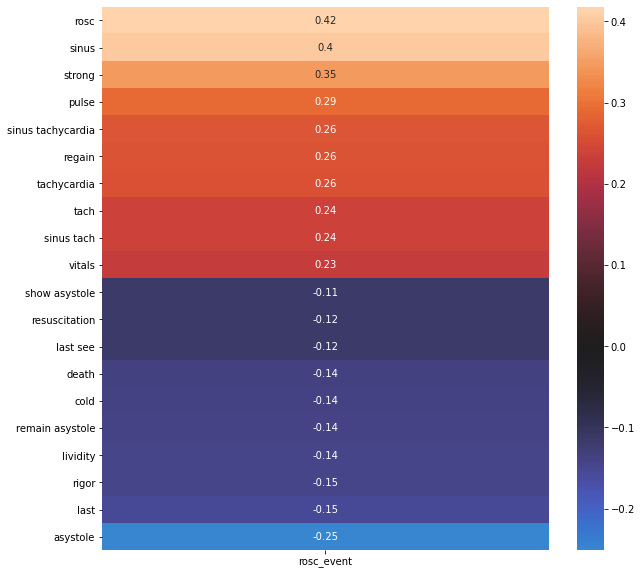

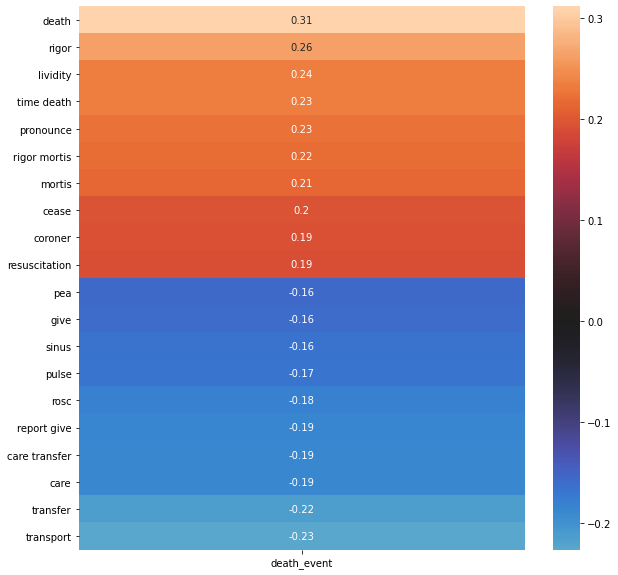

In [28]:
# Tokenize and get ngrams
df_tokenized = tokenize_ngram(df_clean)

# Encode token counts into feature columns
df_encoded = encode_keys(df_tokenized,'ngrams',sample_words(counts_ngrams, 16)) # Change sample_words

# Get correlation heatmap for rosc
correlation_heat_map(df_encoded,'rosc_event')

# Get correlation heatmap for death
correlation_heat_map(df_encoded,'death_event')

TODO :    
1 - Additional stopwords   
2 - Fix lemmatization # Fixed with POS Tagging   
3 - TF-IDF # Complete    
<span style="color:red"> 4 - Word combination correlations </span>   
<span style="color:red"> 5 - ML # Explored CNN with spaCy </span> 

# TF-IDF

In [29]:
def get_tf_idf(df_clean,df_encoded):
    documents = list(df_clean['Chief Narrative'])
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    values = tfidf_vectorizer.fit_transform(documents)

    feature_names = tfidf_vectorizer.get_feature_names()
    tfidf_df = pd.DataFrame(values.toarray(), columns = feature_names)
    
    df_encoded_tfidf = pd.DataFrame(columns = list(df_encoded.columns), index = list(df_encoded.index))
    df_encoded_tfidf = df_encoded_tfidf.loc[:, 'ngrams':].drop(columns = ['ngrams'])
    df_encoded_tfidf.update(tfidf_df)
